<a href="https://colab.research.google.com/github/JohnVicke/deep-learning/blob/main/viktor_malmedal_hyperparameter_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hyperparameter optimization
```
Author: Viktor Malmedal
Mail:   viktormalmedal@gmail.com
umuId:  vima0068
```
Hyperparameter optimization is a two part laboration.

## Part 1
- Compare two models, where one is using regularization (e.g. dropout, batchnormalization) and the other does not.
- Implement early stop for the model that is using regularization.

- Analyze results

## Part 2

- Systematically find optimal hyperparameters using keras tuner on the model with regularization used in part 1.
- Analyze


```
Note:
My Colab ran out of supported GPU time which made it super hard to run all of the tests in a reasonable time. 

I've never run the entire finished project before handing it in. Some of the conclusions and thoughts are based on earlier executions and results.

Since I'm not in the US or Canada I could not purschase Colab Pro (its against their policy).

```

In [18]:
import tensorflow as tf
print(f'TensorFlow version: {tf.__version__}')

import tensorflow.keras 
print(f'Keras version:      {tensorflow.keras.__version__}')

import numpy as np
import sklearn
from sklearn.model_selection import train_test_split

import matplotlib
import matplotlib.pyplot as plt

TensorFlow version: 2.7.0
Keras version:      2.7.0


In [19]:
import sys
if not tf.config.list_physical_devices('GPU'):
    print('No GPU detected. CNNs can be very slow without a GPU')
    if 'google.colab' in sys.modules:
        print('Go to RunTime > change runtime and select a GPU hardware accelerator')
else:
    !nvidia-smi -L

No GPU detected. CNNs can be very slow without a GPU
Go to RunTime > change runtime and select a GPU hardware accelerator


In [20]:
def split_random(data, labels, percent_train=80):
    print('Splitting data into training and validation')
    print(f'Training split     = {percent_train}%')
    print(f'Validation split   = {100-percent_train}%')
    indicies = np.arange(data.shape[0])

    for _ in range(4): 
        indicies = np.random.permutation(indicies)

    
    labels = labels[indicies]
    data = data[indicies]
    rows = data.shape[0]

    end_index = int(rows*percent_train/100)

    train_x = data[:end_index]
    train_y = labels[:end_index]

    validation_x = data[end_index:]
    validation_y = labels[end_index:]

    return (train_x, train_y), (validation_x, validation_y)

In [21]:
def validate_data(data, labels, data_set_name):
    """
        Naive validation, only validets shape of data compared to labels
    """

    nr_images, x, y = data.shape
    print(f'\nRunning validation on {data_set_name}')
    print(f'Number of images   = {nr_images}')
    print(f'Number of labels   = {len(labels)}')
    print(f'Image dimension    = {x}x{y}')
    if nr_images != len(labels):
        print('Number of images does not match number of labels')
    else:
        print('Data is OK ✅')

In [22]:
def get_class_dist(data):
    dist = {}
    for label in data:
        if label in dist:
            dist[label] += 1
        else:
            dist[label] = 1
    return dist


# Loading and visualising the data
- Splits the training data set into a training / validation split (80/20)%
- Runs a naive validation on all data sets to see if the length of labels and images are matching.
- Visualize the data.

In [23]:
from tensorflow.keras.datasets import fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
label_descriptions = ['t-shirt/top', 'trouser', 'pullover', 'dress', 'coat',
                      'sandals', 'shirt', 'sneaker', 'bag', 'ankle boots']

(train_x, train_y), (validation_x, validation_y) = split_random(x_train, y_train)

# increase readability since i will use train_x, train_y from here on 
test_x = x_test
test_y = y_test
test_labels = y_test

validate_data(train_x, train_y, "training")
validate_data(validation_x, validation_y, "validation")
validate_data(test_x, test_y, "test")
distribution = get_class_dist(train_y)

print(f'\nTrain shape         = {train_x.shape}')
print(f'Validation shape    = {validation_x.shape}')
print(f'Test shape          = {x_test.shape}')
print(f'Unique labels       = {np.unique(train_y)}')
print('Label translation   = ---------------------')
for i, label in enumerate(label_descriptions):
    print(f'                     [{i}]: {label}')
print('Train distribution  = ---------------------')
for i, label in enumerate(label_descriptions):
    print('                     {:<20s}: {}'.format(label_descriptions[i], distribution[i]))
print('                     ---------------------')

Splitting data into training and validation
Training split     = 80%
Validation split   = 20%

Running validation on training
Number of images   = 48000
Number of labels   = 48000
Image dimension    = 28x28
Data is OK ✅

Running validation on validation
Number of images   = 12000
Number of labels   = 12000
Image dimension    = 28x28
Data is OK ✅

Running validation on test
Number of images   = 10000
Number of labels   = 10000
Image dimension    = 28x28
Data is OK ✅

Train shape         = (48000, 28, 28)
Validation shape    = (12000, 28, 28)
Test shape          = (10000, 28, 28)
Unique labels       = [0 1 2 3 4 5 6 7 8 9]
Label translation   = ---------------------
                     [0]: t-shirt/top
                     [1]: trouser
                     [2]: pullover
                     [3]: dress
                     [4]: coat
                     [5]: sandals
                     [6]: shirt
                     [7]: sneaker
                     [8]: bag
                     [9]: a

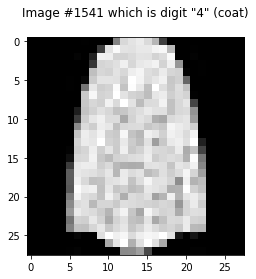

In [24]:
from random import randrange
def plot_image(digit):
    plt.figure()
    plt.imshow(train_x[digit], cmap='gray', interpolation='nearest')
    plt.title(f'Image #{digit} which is digit "{train_y[digit]}" ({label_descriptions[train_y[digit]]})\n')
    plt.show(block=False)

ran_range = len(train_x) - 1
image_digits = [randrange(ran_range)]
plots = [plot_image(a) for a in image_digits]


<Figure size 432x288 with 0 Axes>

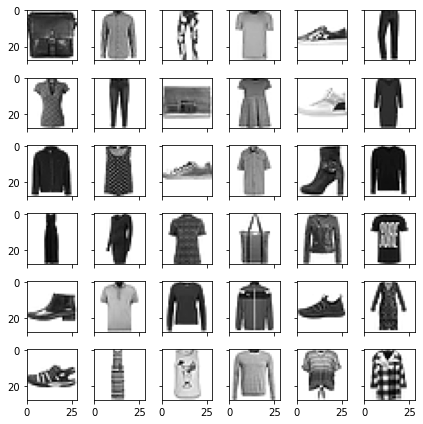

In [25]:
from random import sample
ROWS = 6
random_indicies = sample(range(train_x.shape[0]), ROWS*ROWS)
sample_images = train_x[random_indicies, :]
plt.clf()
fig, axes = plt.subplots(ROWS, ROWS, 
                         figsize=(ROWS, ROWS),
                         sharex=True, sharey=True)

for i in range(ROWS*ROWS):
    subplot_row = i // ROWS
    subplot_col = i % ROWS
    ax = axes[subplot_row, subplot_col]
    plottable_image = np.reshape(sample_images[i,:], (28,28))
    ax.imshow(plottable_image, cmap='gray_r')
    ax.set_xbound([0, 28])

plt.tight_layout()
plt.show()

# Reshaping the data
- Normalize the images (0-255 grayscale into 0-1 float)
- Reshape into correct shape

In [26]:
def reshape_data(data, img_width, img_height, channels_first):
    data = data.astype('float32') / 255.0

    if channels_first:
        data = data.reshape(data.shape[0], 1, img_width, img_height)
    else:
       data = data.reshape(data.shape[0], img_width, img_height, 1) 

    return data


In [27]:
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m:>02}:{s:>05.2f}"

In [28]:
def retrieve(mapping, *keys):
    return (mapping[key] for key in keys)

In [29]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

# Declaring global variables
nr_classes = len(np.unique(train_y))
_, img_width, img_height = train_x.shape
is_channels_first = backend.image_data_format() == 'channels_first'
input_shape = (1, img_width, img_height) if is_channels_first else (img_width, img_height, 1)

train_x = reshape_data(train_x, img_width, img_height, is_channels_first)
test_x = reshape_data(test_x, img_width, img_height, is_channels_first)
validation_x = reshape_data(validation_x, img_width, img_height, is_channels_first)

train_y = to_categorical(train_y, nr_classes)
test_y = to_categorical(test_y, nr_classes)
validation_y = to_categorical(validation_y, nr_classes)

training_data = (train_x, train_y)
validation_data = (validation_x, validation_y)
test_data = (test_x, test_y)

# CNN Model
Defines a CNNModel, storing values for the history/score and provides an easy interface to create new models that will all share a common training and testing strategy. Creating a new model requires a Sequential model in the constructor. This design decicion was made to simplify creating and analyzing different CNN models.

# Main charactaristics

- Using default batchsize (32)
- Running training in 15 epochs with an early stop callback for all models
    - Early stopping is using 3 in patience, which means that it can go back 3 iterations (epochs) and will choose the best weights that it has encountered if the models validation loss starts to increase instead of decreasing (diverging).
- Learning rate is reduced to decrease overfitting (0.001 seems to be a bit too fast in this scenario).
- Using adam as optimizer for adaptive learning rates (considered among the best, if not the best!)
- Using **categorical_crossentropy** for loss & **categorical_accuracy** for accuracy


### Note
```
I know that layers and models can be extended upon using subclasses, 
however I thought that this solution is adequate for the given assignment.
```

In [30]:
class CNNModel():
    batch_size = 32
    epochs     = 25

    sequential = None
    stopped_at = None
    history    = None
    score      = None
    early_stop = False


    def __init__(self, sequential, name, early_stop=False):
        self.name = name
        self.sequential = sequential
        self.sequential.summary()
        self.early_stop = early_stop

    def compile(self):
        optimizer = optimizers.Adam(learning_rate=0.0001)
        self.sequential.compile(loss='categorical_crossentropy',
                                optimizer=optimizer,
                                metrics=['categorical_accuracy'])
    
    def train(self, training_data, validation_data, verbose=1):
        callbacks = []
        if self.early_stop:
            early_stop_monitor = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
            callbacks = [early_stop_monitor]

        train_x, train_y = training_data
        history = self.sequential.fit(train_x, train_y,
                                      batch_size=self.batch_size, 
                                      epochs=self.epochs,
                                      verbose=verbose,
                                      validation_data=validation_data,
                                      callbacks=callbacks)

        # Early stopped
        if self.early_stop and early_stop_monitor.stopped_epoch != 0:
            self.stopped_at = early_stop_monitor.stopped_epoch

        self.history = history.history
    
    def evaluate(self, test_data):
        test_x, test_y = test_data
        score = self.sequential.evaluate(test_x, test_y)
        self.score = score

    def plot_history(self, debug=False):
        train_loss, train_acc, val_loss, val_acc = retrieve(self.history, 
                                                            'loss',
                                                            'categorical_accuracy',
                                                            'val_loss',
                                                            'val_categorical_accuracy')
        if debug:
            print(f'history len : {len(train_loss)}')
            print(f'stopped at  : {self.stopped_at}')
            print(f'Epochs      : {self.epochs}')
            print(f'Train acc   : {len(train_acc)}')
            print(f'Val acc     : {len(val_acc)}')
        
        epoch_range = range(1, self.epochs + 1)

        if self.stopped_at:
            epoch_range = range(1, self.stopped_at + 2)

        early_stop_label = f'Stopped at {self.stopped_at}'
        plt.plot(epoch_range, train_acc, 'bo', label='Training accuracy')
        plt.plot(epoch_range, val_acc, 'b', label='Validation accuracy')
        plt.title(f'Training and validation accuracy ({self.name})')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()

        plt.plot(epoch_range, train_loss, 'bo', color='red', label='Training loss')
        plt.plot(epoch_range, val_loss, 'b', color='red', label='Validation loss')
        plt.title(f'Training and validation loss ({self.name})')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
        print()
    

```
START OF PART 1



# Complex multilayered CNN without regularization

In [31]:
complex_cnn_no_reg = Sequential([

    Conv2D(32, kernel_size=(3,3), padding='same', 
           activation='relu',
           input_shape=input_shape),
    Conv2D(32, kernel_size=(3,3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'),
    Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'),

    Flatten(),
    Dense(128, activation='relu'),
    Dense(nr_classes, activation='softmax'),
])
complex_cnn_model_no_reg = CNNModel(complex_cnn_no_reg, 'No regulrization CNN')

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 conv2d_13 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 conv2d_15 (Conv2D)          (None, 14, 14, 64)        36928     
                                                                 
 flatten_3 (Flatten)         (None, 12544)             0         
                                                      

# Complex multilayered CNN

In [32]:
def get_complex_cnn():
   return Sequential([
            Conv2D(32, kernel_size=(3,3), padding='same', 
                activation='relu',
                input_shape=input_shape),
            Conv2D(32, kernel_size=(3,3), padding='same', activation='relu'),
            MaxPooling2D(pool_size=(2,2)),
            Dropout(0.25),
            BatchNormalization(),

            Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'),
            Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'),
            MaxPooling2D(pool_size=(2,2)),
            Dropout(0.25),

            Flatten(),
            Dense(128, activation='relu'),
            Dense(nr_classes, activation='softmax'),
        ])

complex_cnn_model = CNNModel(get_complex_cnn(), 'Complex multilayered CNN')
complex_cnn_model_early_stop = CNNModel(get_complex_cnn(), 'Complex multilayered CNN with early stop', early_stop=True)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 conv2d_17 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 14, 14, 32)        0         
                                                                 
 batch_normalization_2 (Batc  (None, 14, 14, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_18 (Conv2D)          (None, 14, 14, 64)       

In [33]:
models = [complex_cnn_model, complex_cnn_model_no_reg, complex_cnn_model_early_stop]

In [ ]:
import time
print(f'Starting to train all {len(models)} models....')
global_start_time = time.time()
for model in models:
    print(f'Begin training model: {model.name}')
    start_time = time.time();
    model.compile()
    model.train(training_data, validation_data)
    elapsed_time = time.time() - start_time
    print(f'Training finished for :{model.name} in {hms_string(elapsed_time)}\n')

global_elapsed_time = time.time() - global_start_time
print()
print(f'Finisihed training all {len(models)} model(s) in {hms_string(global_elapsed_time)}')

Starting to train all 3 models....
Begin training model: Complex multilayered CNN
Epoch 1/25
1500/1500 [==============================] - 183s 122ms/step - loss: 0.5621 - categorical_accuracy: 0.7957 - val_loss: 0.3631 - val_categorical_accuracy: 0.8723
Epoch 2/25
1500/1500 [==============================] - 181s 121ms/step - loss: 0.3544 - categorical_accuracy: 0.8714 - val_loss: 0.3076 - val_categorical_accuracy: 0.8898
Epoch 3/25
1500/1500 [==============================] - 183s 122ms/step - loss: 0.3003 - categorical_accuracy: 0.8904 - val_loss: 0.2690 - val_categorical_accuracy: 0.9019
Epoch 4/25
 262/1500 [====>.........................] - ETA: 2:25 - loss: 0.2769 - categorical_accuracy: 0.9042

# Training history (loss + acc)



In [ ]:
for model in models:
    model.plot_history(debug=True)

# Test comparison

In [ ]:
for model in models: 
    model.evaluate(test_data)

best_acc = max(models, key=lambda m: m.score[1])

In [ ]:
print(f'Model with highest test accuracy: {best_acc.name}')
print(f'Test accuracy          = {best_acc.score[1]}')
print(f'Stopped training after = {best_acc.stopped_at if best_acc.stopped_at else best_acc.epochs} epochs')
print()

best_acc.sequential.summary()

# Part 1 conclusion
For part 1 of the assignment, I took my best model from the CNN lab and made a copy of with it with and without regularisation. I also added an earlystop to one of the models which looked at 3 earlier epochs and analyzed the validation loss to later restore the best weights.

All the models were trained on 25 epochs which is a bit much, but I personally thought that it would be a good way to visualize how the models behave when training for a long time and why early stopping is such a good tool.

The first two models (without earlystop) overfit pretty hard, especially the one without regularization. You can see it in the graph where the validation loss goes upp like crazy while the training score still increases.

Regularization is especially good to prevent overfitting since it adds information to a model by removing extra weights from a set of features and redistrubtes them. I.e. it attempts to reduce the variance by simplifying it.

I think by adding regularization, especially dropout layers, i managed to reduce overfitting of the model since I think a lot of the data points have similarites which might have been picked up and interdependantly learned in the neurons (dependancies between neurons which might effect layers).

The model with early stop would stop at around 11-16 epochs before it starts to overfit the data too much.

One interesting aspect is that the overfitted model (with regularization) and the earlystopped model performs pretty much the same. Its never a clear cut winner when evaluating them on the test data. This might indicate that the overfit model is not as overfit as it seems or that the test data is very similar to training/validation data. An overfit model should not be as good on new data as a model thats not overfit (theoretically). To get a better understanding on why this is happening, I woudl run a large number of models and cross validate them on the training set, use different splits and compare the same random seed on the two models. It might also be a case of "human overfitting" where I have not really prepared the data properly since im no expert ;).



```
START OF PART 2
```

In [ ]:
!pip install keras_tuner==1.0.4 -q

import keras_tuner
print('Keras tuner version:', keras_tuner.__version__)

from keras_tuner.tuners import RandomSearch, Hyperband, BayesianOptimization

In [ ]:
def get_tunable_model(hp):
    model = Sequential([
        Conv2D(filters=hp.Int('conv_1_filter', min_value=32, max_value=64,step=16), 
               kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
               activation='relu',
               padding='same',
               input_shape=input_shape),
        Conv2D(filters=hp.Int('conv_2_filter', min_value=32, max_value=64,step=16), 
               kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
               activation='relu',
               padding='same'),
        MaxPooling2D(pool_size=(2,2)),
        Dropout(0.25),
        BatchNormalization(),
        Conv2D(filters=hp.Int('conv_3_filter', min_value=64, max_value=128,step=16), 
               kernel_size=hp.Choice('conv_3_kernel', values = [3,5]),
               activation='relu',
               padding='same'),
        Conv2D(filters=hp.Int('conv_4_filter', min_value=64, max_value=128,step=16), 
               kernel_size=hp.Choice('conv_4_kernel', values = [3,5]),
               activation='relu',
               padding='same'),
        Dropout(0.25),
        Flatten(),
        Dense(
            units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
            activation='relu'
        ),
        Dense(nr_classes, activation='softmax')
    ])

    model.compile()
    optimizer = optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3]))
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['categorical_accuracy'])
    return model

In [ ]:
def get_tuned_model_summary(tuner):
    model = tuner.get_best_models(num_models=1)[0]
    params = tuner.get_best_hyperparameters()[0].values 
    for key, value in params.items():
        print('%20s = %3.4g' %(key, value))
    
    return model, params



In [ ]:
max_trials = 10
execution_per_trial = 2
callbacks = [EarlyStopping('val_loss', patience=3, restore_best_weights=True)]

In [ ]:
tuner = RandomSearch(
    get_tunable_model,
    objective='val_categorical_accuracy',
    max_trials=max_trials,
    executions_per_trial=execution_per_trial,
    directory='ouput',
    project_name='deep_learning_fashion_mnist_vmalm')


In [ ]:
noepochauto = 9
tuner.search(train_x, train_y,
             epochs=noepochauto,
             validation_data=validation_data,
             batch_size=128,
             callbacks=callbacks
             )

In [ ]:
tuned_random_model, tuned_random_model_params = get_tuned_model_summary(tuner)
tuned_random_model.summary()


In [ ]:
tuned_loss, tuned_acc = tuned_model.evaluate(test_x, test_y)

In [ ]:
class BayesianOptimiationTuner(BayesianOptimization):
    def run_trial(self, trial, *args, **kwargs):
        kwargs['batch_size'] = trial.hyperparameters.Int('batch_size', 32, 512, step=32, default=256)
        super(BayesianOptimiationTuner, self).run_trial(trial, *args, **kwargs)

In [ ]:
bayesian_tuner = BayesianOptimiationTuner(
    get_tunable_model,
    objective='val_categorical_accuracy',
    max_trials=max_trials,
    executions_per_trial=execution_per_trial,
    directory='ouput',
    project_name='deep_learning_fashion_mnist_vmalm')

In [ ]:
bayesian_tuner.search(train_x, train_y,
             epochs=noepochauto,
             validation_data=validation_data,
             callbacks=callbacks)

# Part 2 conclusion
The results from keras tuner hyperparameter optimization is quite interesting. It seems like my first two conv layers are too small (according to the tuner). My model had 32 and 32 for the first two layers, while the tuner got the best results with 64 (max limit i set). The tuner also increased the second layers to values close to the maximum i set (128). 

This might indicate that the data requires more filters or feature detectors than what I orginally thought. Since some of the images and categories are very close in how they look, it might need more features to make distinct connections between some categories. However I think that this has the potential to overfit as well since the data is not *that* complex (24x24 gray images, 0-255 pixel values).

Another interesting takeaway is that for the later layers, keras tuner got the best results when increasing the kernel size values to the max i set (5). This might mean that network in later stages needs a larger subsampling after using maxpooling (reducing the size) to get significant results. This might indicate that when an image (data) is reduced in size by using Maxpooling which extracts the pixel with maximum values within the kernel (mask) it then needs a larger mask for the next set of conv layers to get a better feature extraction.

```
Note:
These thoughts are based on the random search, which I completed before my GPU ran out of exec time.
```

I think that with bayesain i could get a better result, since its an optimization problem to find the best hyperparameters and while using random search, it does like the name suggests, searches randomly. Using random search I could have potentionally hit a super good random seed where it returns the best combination of parameters that are possible given my network, however I think that bayesain optimization is a more stable approach which changes the model parameters to minimze the loss function. Bayesain optimization also uses an acquisition function which simply put "[directs sampling to the areas where an improvement over the cuurrent best observation is likely](https://neptune.ai/blog/hyperparameter-tuning-in-python-a-complete-guide-2020)". (Neptune AI, 2021).